# Execution du papier : Unsupervised change detection ACP + kmeans

In [ ]:
! pip install rasterio
! pip install geopandas 
! pip install pyarrow
! pip install matplotlib
! pip install albumentations
!pip install pytorch-lightning


In [4]:
import sys
sys.path.append('../../src')
from satellite_image import SatelliteImage
from utils import *
from plot_utils import *

import yaml
import re
import s3fs
import numpy as np
import matplotlib.pyplot as plt
#import cv2
from PIL import Image as im

from datetime import date
import re
import pyproj


In [5]:
update_storage_access()
environment = get_environment()

root_path = get_root_path()
bucket = environment["bucket"]
path_s3_cayenne_data = environment["sources"]["PLEIADES"][2022]["guyane"]
path_local_cayenne_data = os.path.join(root_path, environment["local-path"]["PLEIADES"][2022]["guyane"])

bucket = environment["bucket"]

path_s3_pleiades_data_2022_guyane = environment["sources"]["PLEIADES"][2022]["guyane"]
path_s3_bdtopo_data_2022_guyane = environment["sources"]["BDTOPO"][2022]["guyane"]
path_local_pleiades_data_2022_guyane = environment["local-path"]["PLEIADES"][2022]["guyane"]
path_local_bdtopo_data_2022_guyane = environment["local-path"]["BDTOPO"][2022]["guyane"]

path_s3_pleiades_data_2022_martinique = environment["sources"]["PLEIADES"][2022]["martinique"]
path_local_pleiades_data_2022_martinique = environment["local-path"]["PLEIADES"][2022]["martinique"]

path_s3_pleiades_data_2017_martinique = environment["sources"]["PLEIADES"][2017]["martinique"]
path_local_pleiades_data_2017_martinique = environment["local-path"]["PLEIADES"][2017]["martinique"]

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

In [ ]:
# DL PLEIADE martinique 2017
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2017_martinique}",
        lpath=f"../{path_local_pleiades_data_2017_martinique}",
        recursive=True)

# DL PLEIADE martinique 2022
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2022_martinique}",
        lpath=f"../{path_local_pleiades_data_2022_martinique}",
        recursive=True)

In [8]:

#crs = 5490 pour la martinique
def gps_to_crs_point(lat,lon,crs) :
    
    # Définir les systèmes de coordonnées de départ et d'arrivée
    src_proj = pyproj.Proj(proj='latlong')
    dest_proj = pyproj.Proj(crs)
    
    # Convertir les coordonnées GPS en coordonnées dans le système de coordonnées de destination (CRS)
    x, y = pyproj.transform(src_proj, dest_proj, lon, lat)
    
    # Retourner les coordonnées dans le CRS spécifié
    return x, y

#ca serait bien de faire une fonction qui cherche dans l'ensemble des données l'image qui contiendra cette coordonées.

def find_image_of_point(coordinate, folder_path, coord_gps = False, crs = None) :
        
    if coord_gps == True :  
        lat, lon = coordinate
        x,y = gps_to_crs_point(lat,lon,crs) #car y=lat et x=lon, les coordonnées gps sont en (lat,lon)
    else :
        x,y = coordinate
                                          
    for filename in os.listdir(folder_path):
        
        # Define a list of delimiter characters
        delimiters = ["-", "_"]

        # Create a regular expression pattern from the delimiter characters
        pattern = "|".join(delimiters)

        # Split the string using the regular expression pattern
        split_filename = re.split(pattern, filename)
        
        left = float(split_filename[2])*1000
        top = float(split_filename[3])*1000
        right = left + 1000.0
        bottom = top - 1000.0
         
        if left <= x <= right:
            if bottom <= y <= top:
                return(folder_path + '/' +filename)
    else : 
        return("Le point n'est pas retrouvé dans ce fichier d'images")
           


## Plus qu'à sortir 2 images nettes  de la martinique

In [13]:
#
# 14.769096787469728, -60.90006133637827 -> badant nuages..
# 14.760965395697703, -60.9138387873933 -> idem..
# 14.473329886162876, -60.91973210908688 -> idem
# 
coordinate  = (14.479541, -61.029952)
folder_path1 = "../data/PLEIADES/2017/MARTINIQUE"
folder_path2 = "../data/PLEIADES/2022/MARTINIQUE"

coord_gps = True
path_t = find_image_of_point(
                                   coordinate,
                                   folder_path1,
                                   coord_gps,
                                    crs = 5490
                                  )
path_tplus1= find_image_of_point(
                                   coordinate,
                                   folder_path2,
                                   coord_gps,
                                    crs = 5490
                                  )

#fromraster !!
#on recharge l'image originale
image_t = SatelliteImage.from_raster(
        path_t,
        date = 2017, 
        n_bands = 3,
        dep = "972"
    )
image_tplus1 = SatelliteImage.from_raster(
        path_tplus1,
        date = 2022, 
        n_bands = 3,
        dep = "972"
    )


#image_t.plot([0,1,2])
#image_tplus1.plot([0,1,2])

/tmp/ipykernel_339/2622687920.py:9: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(src_proj, dest_proj, lon, lat)
/tmp/ipykernel_339/2622687920.py:9: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(src_proj, dest_proj, lon, lat)


In [43]:
import pandas
tile_size =100
list_patch_t = image_t.split(tile_size)
#plot_list_satellite_images(list_patch,[0,1,2])
list_patch_tplusun = image_tplus1.split(tile_size)
list_diff = np.array([ np.ndarray.flatten(abs(im1.array - im2.array)) for im1, im2 in zip(list_patch_t,list_patch_tplusun)])

df = pandas.DataFrame(list_diff)
df.head() # On a bien 400 individus et 30000 collonnes RGBx1000x1000


# refaire la mosaique avec les 2 classes noires et blanc

,0,1,2,3,4,5,6,7,8,9,...,29990,29991,29992,29993,29994,29995,29996,29997,29998,29999
0,238,243,239,234,229,246,6,19,33,55,...,72,74,75,72,73,71,72,75,82,87
1,225,233,13,27,17,7,11,3,236,223,...,6,247,246,14,25,22,6,0,14,28
2,56,60,53,57,58,47,34,18,5,6,...,31,20,22,28,34,28,26,33,29,23
3,28,51,52,41,47,53,61,74,76,80,...,30,23,22,20,15,14,23,31,15,253
4,9,8,8,9,10,9,12,16,12,12,...,239,224,217,210,242,15,28,21,28,52


## PCA

In [44]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pcacomp = pca.fit_transform(df)# on a les projections sjur les axes là dedans
pcacomp.shape

(400, 10)

## k means

In [47]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(pcacomp)
kmeans.labels_ # Ok 2 classes 0 1

# je créer une image noir

arr_black = np.zeros((3,tile_size,tile_size))


## Représentation

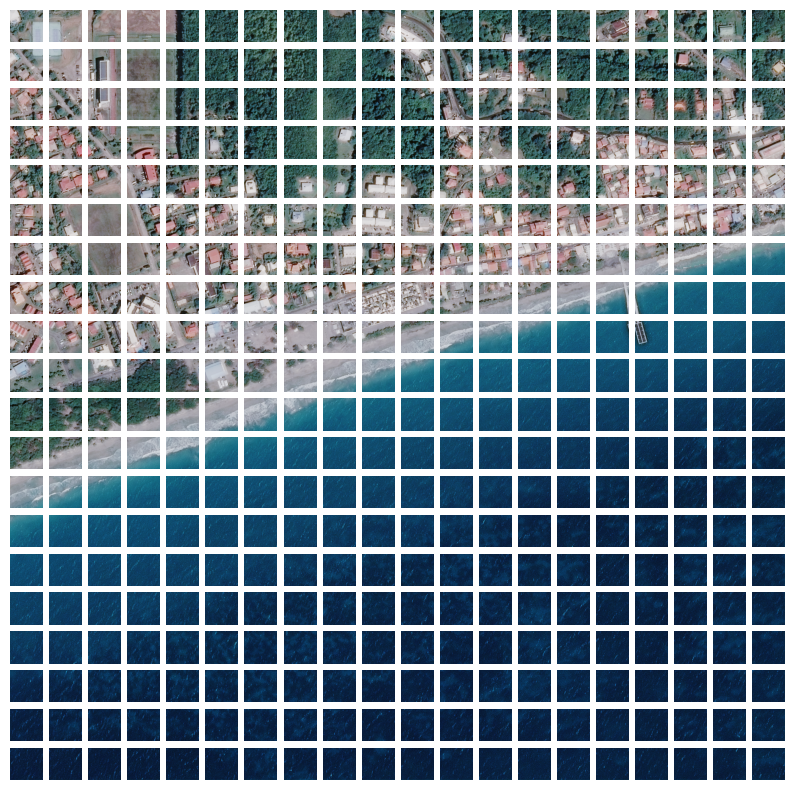

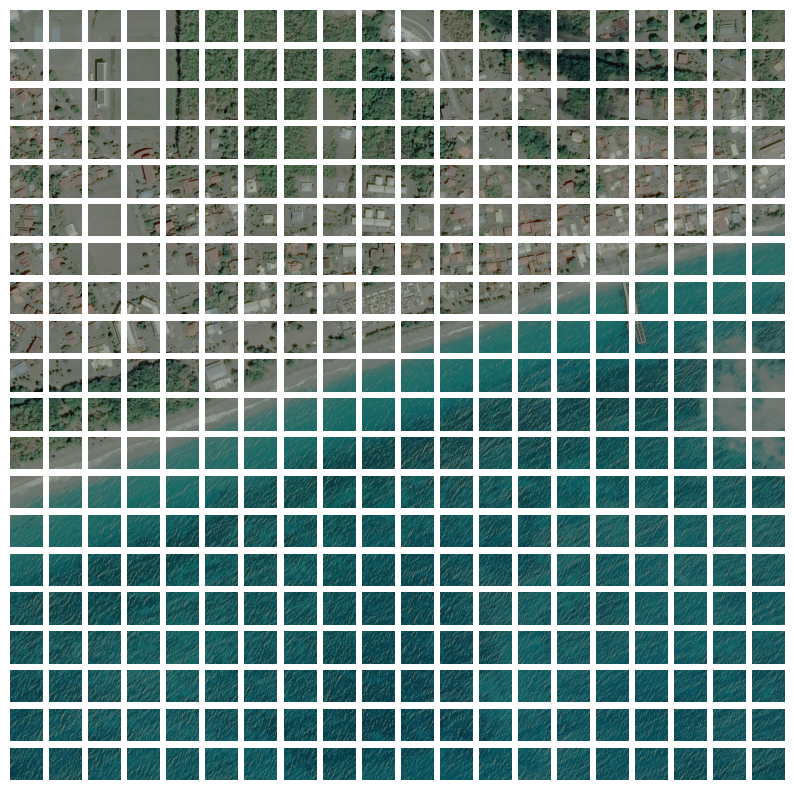

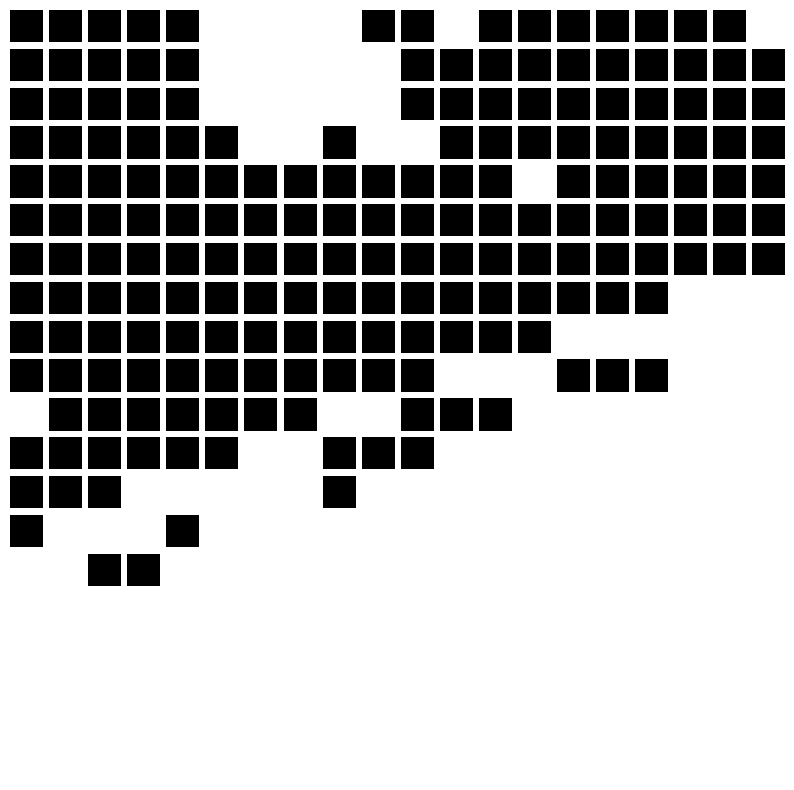

In [58]:

liste_patch_noir_blanc = [SatelliteImage(
        array = arr_black+i ,
        crs = 2,
        bounds = img.bounds,
        transform = None,
        n_bands= 3,
        filename = "",
        dep = None,
        normalized = True
    ) for i,img in  zip(kmeans.labels_,list_patch_t) ]

plot_list_satellite_images(list_patch_t,[0,1,2])
plot_list_satellite_images(list_patch_tplusun,[0,1,2])

plot_list_satellite_images(liste_patch_noir_blanc,[0,1,2])

In [62]:
numeric_vector = [np.sum(abs(im1.array - im2.array)) for im1, im2 in zip(list_patch_t,list_patch_tplusun)]

category_vector = kmeans.labels_

# Create a DataFrame from the data
df = pandas.DataFrame({'numeric_vector': numeric_vector, 'category_vector': category_vector})

# Group the data by categories and compute the mean
grouped = df.groupby('category_vector')
mean_by_category = grouped.mean()

print(mean_by_category)


                 numeric_vector
category_vector                
0                  2.617885e+06
1                  5.512980e+06


1 = les changements
0 (noir moins de changements) ?


Planning :
1) Difference image + decoupage en petit patch
2) ACP ou tsne
3) k means
4)class avec change max
5) eventuellement classifier le patch en sortie
6) TSNE <3 https://cs.nyu.edu/~roweis/papers/sne_final.pdf -> on regarde pour chaque paire 2 points, on calcule la proba que le point en question soit voisin pij = dist(xi,xj)/sum(dist(xi,xk) k diff i.  On obtient des poj basés sur les xk en grande dimension. On essaie de trouver des vecteurs de plus petite dimension yi à la place de chaque xi. pour sque qij -= dist(xi,xj)/sum(dits(yi,yk)) soit proche des pij et on aura donc notre embedding. ! marche bien pour le noim convexe. s'intéresse plus aux similarités locales ? car ion en regarde pas les voisins après un une certaine distance(cf le sigma de la gaussienne neutralise la distance des points trop eloignés).

## Faire en sort que les plots retrounent des objets plots ?